In [1]:
# Connect notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Navigate to the shared drive folder
%cd /content/drive/'My Drive'/'Pig Proteomics Summer Project'
!pwd
!ls

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project
/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project
'2021-06-21 Introduction to Proteomes.ipynb'
'2021-06-28 Reactome and Uniprot.ipynb'
'2021-06-29 Identifying characteristics of an unreliable protein.gslides'
 data
 gene_PE.ipynb
 histogram.ipynb
'machine learning.gslides'
 model_v1.ipynb
 model_v2.ipynb
 output
 pe_scores.ipynb
 pig_model.ipynb
 scratch
'Summer Project.gdoc'
 violin.ipynb
'Week 1 Introduction slides.gslides'
'Week 3 Findings.gslides'


In [18]:
!pip install fastaparser

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from math import *
from scipy.stats import zscore


In [19]:
import fastaparser
import pandas as pd

def parse_fasta_file(file_name):
  """
  this function parses a FASTA database and returns it as a mapping from the
  header of the protein to the amino acid sequence it corresponds to
  mapping: {header: sequence}
  """
  out_dict = {}
  fastaRaw = [] #uses quick parsing method
  with open(file_name) as fasta_file:
      parserQuick = fastaparser.Reader(fasta_file, parse_method = 'quick')
      
      for seq in parserQuick:
          fastaRaw.append(seq)
          
  headerList = []
  seqList = []

  for k in fastaRaw:
      headerList.append(k.header)
      seqList.append(k.sequence)

  if len(headerList) != len(seqList):
      raise ValueError("Number of headers =/= number of sequences")

  for i in range(len(headerList)):
      out_dict[headerList[i]] = seqList[i]

  return out_dict

def extract_protein_length(file_name):
  """
  gets protein length in the following format:
  {accession ID : protein length}
  """
  out_dict = parse_fasta_file(file_name)
  protein_to_length = {}

  for key in out_dict.keys():
    indice = []
    for k in range(len(key)):
      t = key[k]
      if '|' in t:
        indice.append(k)
    accession = key[indice[0] + 1 : indice[1]]

    protein_to_length[accession] = len(out_dict[key])


  return protein_to_length

def extract_PE_scores(file_name):
  """
  gets PE score in the following format:
  {accession ID : PE score}
  """
  out_dict = parse_fasta_file(file_name)
  protein_to_PE_score = {}

  for key in out_dict.keys():
    indice_accession = []
    indice_PE = []
    for i in range(len(key)):
      t_accession = key[i]
      if '|' in t_accession:
        indice_accession.append(i)    
    accession = key[indice_accession[0] + 1 : indice_accession[1]]

    for j in range(len(key)):
      t_pe = key[j:j+3]
      if 'PE=' in t_pe:
        indice_PE.append(j)
    
    pe_score = int(key[indice_PE[0] + 3 : indice_PE[0] + 4])
    protein_to_PE_score[accession] = pe_score
  
  return protein_to_PE_score

def extract_confirmed_isoforms(isoform_file):
  """
  {accession ID : num of confirmed isoforms}
  specifically takes isoform file
  """
  protein_to_length = extract_protein_length(isoform_file) #{accession ID : length of sequence}
  protein_to_isoform = {}

  set_of_proteins = list(set(protein_to_length.keys()))
  set_of_isoforms = [x for x in set_of_proteins if '-' in x] #list of isoforms
  set_of_no_isoforms = [x for x in set_of_proteins if '-' not in x] #list of non-isoforms

  for protein in set_of_no_isoforms:
    c = 0
    for k in set_of_isoforms:
      if protein in k:
        c = c + 1
    
    protein_to_isoform[protein] = c
  
  return protein_to_isoform

def reference_proteome(file_name, proteome_file):
  """
  returns 1 if protein is in reference proteome, 0 if protein is not in reference proteome
  file_name -> full db
  proteome_file -> proteome db
  """
  all_proteins = list(set(extract_protein_length(file_name).keys()))
  proteome_proteins = list(set(extract_protein_length(proteome_file).keys()))

  protein_to_binary = {}
  for protein in all_proteins:
    if protein in proteome_proteins:
      protein_to_binary[protein] = 1
    elif protein not in proteome_proteins:
      protein_to_binary[protein] = 0
  
  return protein_to_binary

In [20]:
def protein_to_features(file_name, proteome_file, isoform_file):
  """
  inputs:
  file_name -> full protein db
  proteome_file -> reference proteome db
  isoform_file -> full protein db with isoforms
  creates dictionary in the following format:
  {accession ID : [protein length, PE score, num of confirmed isoforms]}
  """
  #hopefully the keys of each dictionary defined above are identical to each other
  protein_to_length = extract_protein_length(file_name)
  protein_to_PE_score = extract_PE_scores(file_name)
  protein_to_isoform = extract_confirmed_isoforms(isoform_file)
  protein_to_binary = reference_proteome(file_name, proteome_file)

  protein_to_features = {}

  for key in list(protein_to_length.keys()):
    protein_to_features[key] = [protein_to_length[key],
                                protein_to_PE_score[key],
                                protein_to_isoform[key],
                                protein_to_binary[key]]
  
  return protein_to_features

def protein_features_dataframe(protein_features_dict):
  """
  input: protein_to_features output
  output: dataframe; headers = ['Protein Accession ID', 'Length', 'PE Score', '#Isoforms (confirmed)', 'In reference proteome']
  """  
  accession = []
  length = []
  pe_score = []
  confirmed_isoforms = []
  ref_proteome = []

  for protein in list(protein_features_dict.keys()):
    accession.append(protein)
    length.append(protein_features_dict[protein][0])
    pe_score.append(protein_features_dict[protein][1])
    confirmed_isoforms.append(protein_features_dict[protein][2])
    ref_proteome.append(protein_features_dict[protein][3])
  
  d = {'Protein Accession' : accession,
       'Length' : length,
       'PE Score' : pe_score,
       '#Confirmed Isoforms' : confirmed_isoforms,
       'In Reference Proteome' : ref_proteome}

  return pd.DataFrame(data = d)


# **Constructing pig dataframe**

In [6]:
%cd data

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/data


In [8]:
file_pig_isoforms = 'sus_scrofa_isoforms.fasta'
file_pig_proteome = 'sus_scrofa_uniprot-proteome_UP000008227.fasta'
file_pig_all = 'sus_scrofa_all.fasta'

In [ ]:
protein_to_features_dict = protein_to_features(file_pig_all, file_pig_proteome, file_pig_isoforms)
protein_to_features_dict

In [10]:
df_protein_features = protein_features_dataframe(protein_to_features_dict)
df_protein_features

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome
0,Q9TV69,335,1,0,1
1,P27594,663,2,0,1
2,P00355,333,1,0,1
3,Q5I2M3,1030,2,0,1
4,Q95JC9,676,1,2,1
...,...,...,...,...,...
120921,Q8SQ26,322,2,0,1
120922,Q6Q7J2,445,2,0,1
120923,F1S5L4,826,2,0,1
120924,P50132,363,3,0,1


In [11]:
%cd -

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project


In [11]:
%cd output

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/output


In [13]:
df_protein_features.to_csv("sus_scrofa_features_all.csv")

# Creating Sus Scrofa Model

In [14]:
w = np.array([-0.00409286, -1.41677154,  0.59926468])
b = -0.6384198099664238


In [21]:
def jaccard_overlap(predicted, reference):
  """
  computes jaccard overlap; J = A.intersection(B)/A.union(B)
  """
  return len(predicted.intersection(reference))/len(predicted.union(reference))

def sigmoid_function(z):
  """
  evaluates sigma(z) = 1/(1 + exp(-z))
  """
  return 1/(1 + np.exp(-z))

def z_score_dataframe(all):
    """
    returns df w/ z-scores
    """
    #all
    all_input = all.drop(all.columns[[0,4]], axis=1) #[Length, PE Score, #Confirmed Isoforms]
    all_input = all_input.apply(zscore)
    all_proteins = list(all['Protein Accession'])
    all_binary = list(all['In Reference Proteome'])
    all_z_length = list(all_input['Length'])
    all_z_pe_score = list(all_input['PE Score'])
    all_z_isoforms = list(all_input['#Confirmed Isoforms'])

    #creating all dataframe with z-scores
    all['Protein Accession'] = all_proteins
    all['Length'] = all_z_length
    all['PE Score'] = all_z_pe_score
    all['#Confirmed Isoforms'] = all_z_isoforms
    all['In Reference Proteome'] = all_binary

    return all

def reliable_proteins(all, w, b, threshold = 0.5):
    """
    output: list of proteins that are deemed reliable by software
    """
    proteins_predict = []

    all = z_score_dataframe(all)

    for k in range(len(all['Length'])):
        L = [list(all['Length'])[k],
            list(all['PE Score'])[k],
            list(all['#Confirmed Isoforms'])[k]]
        
        z = w[0]*L[0] + w[1]*L[1] + w[2]*L[2] + b
        p = sigmoid_function(z)

        if p >= threshold:
            proteins_predict.append(list(all['Protein Accession'])[k])

    return proteins_predict


In [17]:
!pwd

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/output


In [15]:
pig_all = pd.read_csv("pig_all_table_PE.csv")
pig_proteome = pd.read_csv("pig_proteome_table_PE.csv")

In [16]:
proteome_list = list(pig_proteome['accession'])

In [ ]:
predicted_proteins = reliable_proteins(df_protein_features, w, b)
predicted_proteins

In [22]:
jaccard_overlap(set(predicted_proteins), set(proteome_list))

0.3322012966965113

In [23]:
common_proteins = set(predicted_proteins).intersection(set(proteome_list))
difference_protein = set(proteome_list).difference(set(predicted_proteins))

In [24]:
len(difference_protein)

31500

In [25]:
len(common_proteins)

18292

# **PE Score Analysis**

In [ ]:
pe_score_common = [df_protein_features[df_protein_features['Protein Accession'] == x]['PE Score'].values[0] for x in list(common_proteins)]
pe_score_common

Following histogram is for predicted proteins in common with the reference proteome

(array([1.7008e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.2810e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

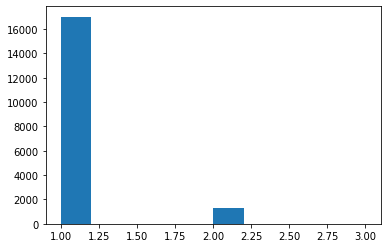

In [60]:
plt.hist(pe_score_common)

Following histogram is for the proteins not picked up by the software

In [71]:
pe_score_diff = [df_protein_features[df_protein_features['Protein Accession'] == x]['PE Score'].values[0] for x in list(difference_protein)]


(array([13038.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 18462.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ]),
 <a list of 10 Patch objects>)

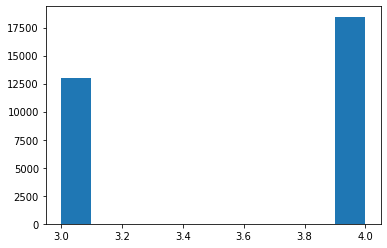

In [72]:
plt.hist(pe_score_diff)

## **Protein Sequence Length Analysis**

In [61]:
length_common = [df_protein_features[df_protein_features['Protein Accession'] == x]['Length'].values[0] for x in list(common_proteins)]

In [63]:
def create_unnormalized_plot(data1, binwidth = 10, xlimit = (0,3000), organism = 'Sus scrofa'):
  """
  creates unnormalized histogram for any dataset
  default values: binwidth = 10, xlimit = (0,3000)
  """
  plt.hist(data1, bins= range(min(data1), max(data1) + binwidth, binwidth))
  plt.xlim(xlimit)
  plt.xlabel("Protein Sequence Length")
  plt.ylabel("Number of Proteins in each bin of length")
  plt.title("")
  plt.title(str("Unnormalized plot of " + str(organism) + "; Binwidth = " + str(binwidth)))

The following histogram is for the created sus scrofa model (predicted proteins)

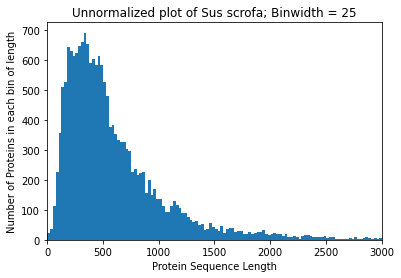

In [65]:
create_unnormalized_plot(length_common, binwidth=25)

# Load .npy file

In [3]:
%cd output

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/output


In [5]:
import numpy as np
predicted_proteins = np.load("pig_predicted.npy", allow_pickle=True)

In [8]:
len(predicted_proteins.tolist())

23563

In [9]:
predicted_proteins = predicted_proteins.tolist()

In [10]:
%cd -

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project
